# Topic Modelling: Airbnb Reviews 
##### Problematique : Are people talking about COVID-19 in the reviews? What are they talking about?

In [252]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pylab as pl
import seaborn as sns

## Dataset

The dataset source is InsideAirbnb.  

We will use the dataset cleaned and labelled during sentiment analysis

"reviews2020-label.csv":
* only contains reviews in 2020
* dataset cleaned (drop empty reviews, drop non-english reviews, drop automatic posts)
* labelled and scored by VADER model ---> 'label' & 'score' columns

In [244]:
# ------ Load the data ------
reviews_2020 = pd.read_csv('reviews2020-label.csv')

In [246]:
# ------ drop the index colum ------
reviews_2020= reviews_2020[['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments', 'lang', 'score', 'label']]

In [247]:
reviews_2020.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,score,label
0,5396,589499566,2020-01-06,28821240,Adrien,"Awesome, safe building, clean room, but more i...",english,0.9652,pos
1,5396,607910128,2020-02-19,26509433,Roberto,Great location and very helpful host.,english,0.8016,pos
2,5396,611549316,2020-02-27,8898065,Brenda,Location location location! This flat is perfe...,english,0.9908,pos
3,5396,612203113,2020-02-29,46597362,Carolyn,Great location. We were a bit bummed the wifi ...,english,0.8917,pos
4,5396,614805142,2020-03-06,269002087,Lilla,This appartment is very nice and clean. It's r...,english,0.9711,pos


## Gensim Word2Vec:  COVID related words in the document

Reason of filtering the data with only COVID-related document is that: 
* I've already run NMF model with the whole cleaned dataset, and COVID related words didn't appear in the top words --> my guess is that not a lot of reviews are talking about lockdown
* Hence, the solution will be finding out COVID related words and filter the dataset with only COVID related reviews

In [227]:
import gensim

In [228]:
# ------  step 1: preprocessing texts ------
documents = reviews_2020['comments'].apply(lambda x: gensim.utils.simple_preprocess(x)).values

# ------ step 2: process documents ------
    # time depends on vector size, here 150
model = gensim.models.Word2Vec(documents,
                              size=150,
                              window=10,
                              min_count=2,
                              workers=4)
model.save('reviews.model')

In [229]:
# ------ find out the most similar words to covid ------
model.wv.most_similar(positive='covid')

[('pandemic', 0.916935384273529),
 ('coronavirus', 0.913436770439148),
 ('corona', 0.8834292888641357),
 ('lockdown', 0.8633388876914978),
 ('outbreak', 0.8534713983535767),
 ('virus', 0.8475683927536011),
 ('crisis', 0.8055170178413391),
 ('quarantine', 0.774040699005127),
 ('situation', 0.7439684271812439),
 ('shutting', 0.7367639541625977)]

In [230]:
model.wv.most_similar(positive='coronavirus')

[('covid', 0.913436770439148),
 ('outbreak', 0.8907583951950073),
 ('pandemic', 0.8766135573387146),
 ('virus', 0.8666505813598633),
 ('corona', 0.8634638786315918),
 ('crisis', 0.8507940769195557),
 ('lockdown', 0.8292901515960693),
 ('ban', 0.7842148542404175),
 ('situation', 0.7722944021224976),
 ('quarantine', 0.7620464563369751)]

In [233]:
model.wv.most_similar(positive='lockdown')

[('pandemic', 0.899053156375885),
 ('covid', 0.8633388876914978),
 ('coronavirus', 0.8292901515960693),
 ('corona', 0.7991920709609985),
 ('virus', 0.7964370846748352),
 ('outbreak', 0.7878764867782593),
 ('quarantine', 0.7811530232429504),
 ('december', 0.7405706644058228),
 ('season', 0.7320390939712524),
 ('restrictions', 0.724960446357727)]

### Here are the words I decided as the condition of COVID related reviews :
covid, corona, pandemic, outbreak, lockdown, virus, crisis, quarantine, coronavirus, confinement, situation, shutting, ban, restrictions

In [235]:
# ------ create a function to filter only COVID-19 related reviews ------

def talk_covid(text):
    m = re.match(r".*(covid|corona|pandemic|outbreak|lockdown|virus|crisis|quarantine|coronavirus|confinement|situation|shutting|ban|restrictions).*",text)
    if m:
        return True
    else:
        False

In [237]:
# ------ apply the function  ------
reviews_2020['covid']= reviews_2020['comments'].apply(lambda x: talk_covid(x))

In [238]:
# ------ print some examples of filtered review  ------
i=0
for element in reviews_2020.loc[ reviews_2020['covid']==True]['comments']:
    i = i++1
    if i <5:
        print(i)
        print(element)
        print("-------")

1
My husband and I enjoyed our stay at Ben's place for our visit to Paris for our honeymoon. He was accommodating per our early flight arrival time and allowed us to store our luggage until the apartment was ready. The apartment was very clean and spacious, the bed was the most comfortable bed we slept on while traveling all around Europe for this trip. The apartment was located close to many shops, restaurants and within walking distance of most 'tourist attractions'. Would definitely recommend to others!
-------
2
Okay, I'm writing this in such a bad situation in our world. Firstly, we are a family of 4, me, my wife, and 2 of our toddlers. We were travelling Europe before arriving in France to visit a sister in Paris and to go to Colmar. All of a sudden, an ongoing pandemic (COVID-19) worsened the situation in France and we had to go on a lockdown, means our trip to Colmar is cancelled and we're stuck in Paris, and can't go out except for groceries and exercise. Our first 3 nights in

In [240]:
# ------ filtered dataset  ------
covid = reviews_2020.loc[ reviews_2020['covid']==True]

In [241]:
covid.head()

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,score,label,covid
99,145,35065,589942462,2020-01-07,178695823,Brittany,My husband and I enjoyed our stay at Ben's pla...,english,0.9507,pos,True
206,352,93287,619802378,2020-03-19,9494300,Billy And Miranda,"Okay, I'm writing this in such a bad situation...",english,0.9891,pos,True
297,557,192162,590351362,2020-01-08,290162141,Roberta,Cristina’s studio is a really charming Place! ...,english,0.9434,pos,True
302,563,192162,606236462,2020-02-16,61463035,Brandon,Cristina and her husband were very communicati...,english,0.8805,pos,True
348,634,221754,594716490,2020-01-19,1384432,Kim,"Merci, Valerie! I had a wonderful stay in Vale...",english,0.9943,pos,True


In [260]:
# ------ shape of the filtered dataset ------
covid.shape

(898, 11)

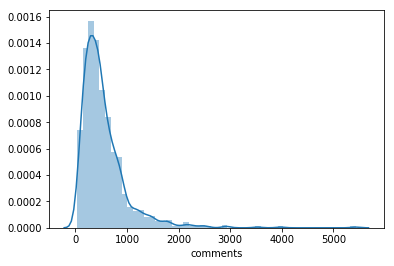

In [261]:
# ------ COVID reviews length distribution ------
sns.distplot(covid["comments"].str.len())

In [262]:
# ------ mean sentiment score  ------
covid['score'].mean()

0.7797768374164814

Text(0.5,1,'COVID-RELATED Reviews')

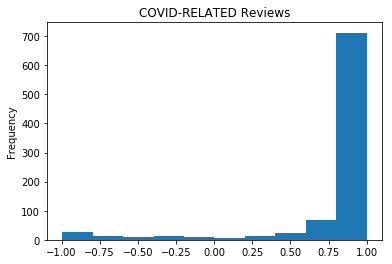

In [263]:
# ------ distribution of sentiment score ------

covid['score'].plot(kind='hist')
pl.title("COVID-RELATED Reviews")

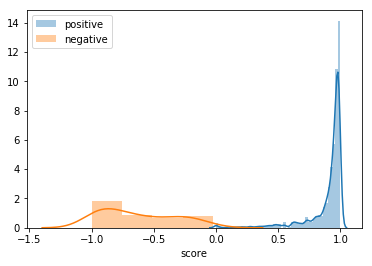

In [264]:
# ------ plot the distribution of the scores for positive and negative reviews  ------
sns.distplot(covid.loc[covid['label']=='pos', 'score'])
sns.distplot(covid.loc[covid['label']=='neg', 'score']);
plt.legend(labels=['positive', 'negative'])

------------

# NMF Modelling
Objective: to find the top topics in COVID-related reviews  
Dataset : covid-realted reviews ( covid )

In [266]:
import nltk
nltk.download('worTaidnet')

[nltk_data] Error loading worTaidnet: Package 'worTaidnet' not found
[nltk_data]     in index


False

## Data Preprocessing

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


In [268]:
# ------ Loading Gensim and nltk libraries ------

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(400)

In [277]:
# ------ stemmer ------ #

stemmer = SnowballStemmer("english")

In [281]:
# ------ function to perform the pre processing steps on the entire dataset ------

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [282]:
# ------ generate the preprocessed data------ #

preprocessed= [" ".join(preprocess(covid.comments[idx])) for idx in covid.index]

### Tfidf & NMF

In [300]:
# ------ prepare for Tfidf & NMF modelling ------ #

n_features = 4000
n_components = 3
n_top_words = 20

we will also remove custom stop words during before vectorizing:  
'would', 'apart', 'stay'

In [298]:
# ------ Tfidf vectorize the text ------ #

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

custom_stop_words = ['would', 'apart', 'stay']
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                            max_features=n_features, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))

Created document-term matrix of size 898 x 1806


In [299]:
# ------ NMF topic modelling ------ #
#   alpha=0 means no regularization, l1_ratio=.5, the penalty is a combination of L1 and L2

from sklearn import decomposition
nmf = decomposition.NMF(n_components = n_components, max_iter = 200, random_state=1, alpha=.1, l1_ratio=.5)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated W(document-topic)) matrix of size %s and H (topic-word) matrix of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()

# ------ Print top words in each topic ------ #

for topic_idx, topic in enumerate(H):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated W(document-topic)) matrix of size (898, 3) and H (topic-word) matrix of size (3, 1806)
Topic #0:
great place locat husband pari love walk recommend perfect restaur comfort metro close need time clean flat easi host shop

Topic #1:
cancel coronavirus trip time refund travel covid host pari unfortun help corona kind restrict communic book earli pandem virus understand

Topic #2:
situat nice clean host hotel help good thank place room small peopl answer locat excel conveni studio difficult great fast



In [296]:
# ------ generate topic key words ------ #

def show_topics(vectorizer=tfidf_vectorizer, model=nmf, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, model=nmf, n_words=20)        

# ------ Topic - Keywords Dataframe ------ #
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,great,stay,place,locat,husband,pari,love,walk,recommend,perfect,comfort,restaur,need,metro,close,time,clean,flat,easi,host
Topic 1,cancel,coronavirus,trip,time,refund,travel,covid,host,stay,pari,unfortun,help,corona,kind,restrict,communic,book,earli,pandem,virus
Topic 2,situat,nice,clean,host,hotel,help,good,place,room,thank,small,peopl,answer,locat,conveni,excel,studio,difficult,fast,great


Here we can see the three topics are quite different topics :  
* Topic 0 : Location/Couples/Recommend
* Topic 1 : Coronavirus/Refund/Cancellation
* Topic 2 : Nice/Clean/Help

In [306]:
# ------ Define Topic Names ------ #
Topics_theme = ['Location/Couples/Recommend', 'Coronavirus/Refund/Cancellation', 'Nice/Clean/Help']
df_topic_keywords['topic_theme'] = Topics_theme

In [307]:
df_topic_keywords.set_index('topic_theme', inplace=True)

In [308]:
# ------ Keywords - Topic Dataframe ------ #
df_topic_keywords.T

topic_theme,Location/Couples/Recommend,Coronavirus/Refund/Cancellation,Nice/Clean/Help
Word 0,great,cancel,situat
Word 1,stay,coronavirus,nice
Word 2,place,trip,clean
Word 3,locat,time,host
Word 4,husband,refund,hotel
Word 5,pari,travel,help
Word 6,love,covid,good
Word 7,walk,host,place
Word 8,recommend,stay,room
Word 9,perfect,pari,thank


In [310]:
# ------ Create Document - Topic Matrix ------ #
nmf_output = nmf.transform(tfidf) 

# ------ column names ------ #
topicnames = df_topic_keywords.T.columns
# topicnames = ["Topic" + str(i) for i in range(20)]

# ------ index names ------ #
docnames = ["Doc" + str(i) for i in range(len(covid))]

# ------ Make the pandas dataframe ------ #
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=covid.index)

# ------ Get dominant topic for each document ------#
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
covid['topic'] =  dominant_topic

/Users/IvoryDaae/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [311]:
covid.head()

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,score,label,covid,topic
99,145,35065,589942462,2020-01-07,178695823,Brittany,My husband and I enjoyed our stay at Ben's pla...,english,0.9507,pos,True,0
206,352,93287,619802378,2020-03-19,9494300,Billy And Miranda,"Okay, I'm writing this in such a bad situation...",english,0.9891,pos,True,1
297,557,192162,590351362,2020-01-08,290162141,Roberta,Cristina’s studio is a really charming Place! ...,english,0.9434,pos,True,0
302,563,192162,606236462,2020-02-16,61463035,Brandon,Cristina and her husband were very communicati...,english,0.8805,pos,True,0
348,634,221754,594716490,2020-01-19,1384432,Kim,"Merci, Valerie! I had a wonderful stay in Vale...",english,0.9943,pos,True,0


In [315]:
# ------ count number of each topic ------ #
covid['topic'].value_counts()

0    675
1    136
2     87
Name: topic, dtype: int64

In [331]:
# ------ Print mean sentiment score for each topic ------ #
for i in range(n_components):
    topic= "Topic " + str(i+1)
    print(topic)
    print(Topics_theme[i])
    print(covid.loc[covid['topic']==i]['score'].mean())
    print('----------------')
    i++1

Topic 1
Location/Couples/Recommend
0.8729697777777777
----------------
Topic 2
Coronavirus/Refund/Cancellation
0.3366272058823529
----------------
Topic 3
Nice/Clean/Help
0.7494678160919541
----------------


### Word Cloud for each topic

In [323]:
# ------ Create pandas dataframe for the topics ------ #
mydf = pd.DataFrame({"feature_name": feature_names}) 

for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

reviews_topic1 = []
reviews_topic2 = []
reviews_topic3 = []

for order_id, key, num1, num2, num3 in mylist:
    reviews_topic1.append((key, num1))
    reviews_topic2.append((key, num2))
    reviews_topic3.append((key, num3))
    reviews_topic4.append((key, num4))

reviews_topic1 = sorted(reviews_topic1, key=lambda myword: myword[1], reverse=True)
reviews_topic2 = sorted(reviews_topic2, key=lambda myword: myword[1], reverse=True)
reviews_topic3 = sorted(reviews_topic3, key=lambda myword: myword[1], reverse=True)


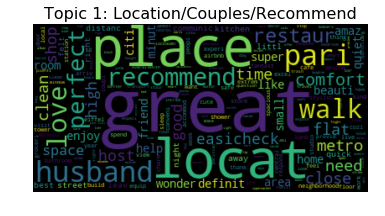

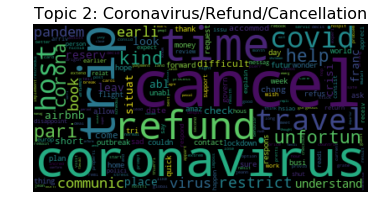

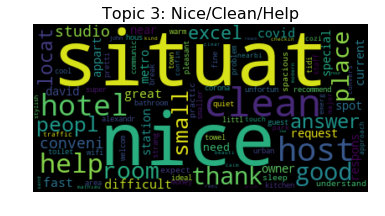

In [324]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

%matplotlib inline

def draw_wordcloud(dict, topic_number):
    wc = WordCloud(max_words=1000)    
    wordcloud = WordCloud().generate_from_frequencies(dict)
    title = 'Topic %s' %str(topic_number) + ": " + Topics_theme[topic_number-1]
    plt.title(title, size = 16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

draw_wordcloud(dict(reviews_topic1), topic_number=1)
draw_wordcloud(dict(reviews_topic2), topic_number=2)
draw_wordcloud(dict(reviews_topic3), topic_number=3)


In [332]:
# Prediction example
text_new = preprocessed[0:5]
tfidf_new = vectorizer.transform(text_new)
DT_new = nmf.transform(tfidf_new)

-------------

# LDA Modelling 

In [333]:
import sys;
from nltk.corpus import stopwords;
import nltk;
from gensim.models import ldamodel
import gensim.corpora;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;

## Data Preprocessing

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


In [334]:
# ------ this time we will change the stemmer ------ #
stemmer = PorterStemmer()

In [347]:
# ------  function to perform the pre processing steps on the entire dataset ------ #

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            if lemmatize_stemming(token) not in ('pari', 'apart', 'stay','place'):
                result.append(lemmatize_stemming(token))
            
    return result

In [348]:
processed_docs = []

for doc in covid['comments'] :
    processed_docs.append(preprocess(doc))

In [349]:
# ------ Preview 'processed_docs' ------ #
print(processed_docs[:2])

[['husband', 'enjoy', 'visit', 'honeymoon', 'accommod', 'earli', 'flight', 'arriv', 'time', 'allow', 'store', 'luggag', 'readi', 'clean', 'spaciou', 'comfort', 'sleep', 'travel', 'europ', 'trip', 'locat', 'close', 'shop', 'restaur', 'walk', 'distanc', 'tourist', 'attract', 'definit', 'recommend'], ['okay', 'write', 'situat', 'world', 'firstli', 'famili', 'wife', 'toddler', 'travel', 'europ', 'arriv', 'franc', 'visit', 'sister', 'colmar', 'sudden', 'ongo', 'pandem', 'covid', 'worsen', 'situat', 'franc', 'lockdown', 'mean', 'trip', 'colmar', 'cancel', 'stick', 'groceri', 'exercis', 'night', 'smaller', 'decid', 'need', 'space', 'kid', 'spend', 'night', 'luckili', 'jean', 'francoi', 'avail', 'move', 'earli', 'thank', 'allow', 'noon', 'govern', 'peopl', 'noon', 'spacey', 'elev', 'typic', 'european', 'expect', 'mind', 'bedroom', 'comfort', 'live', 'area', 'larg', 'kitchen', 'proper', 'amaz', 'thing', 'locat', 'supermarket', 'butcher', 'boulangeri', 'fromageri', 'legendari', 'stohrer', 'patis

In [350]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [351]:
# ------ Checking dictionary created ------ #

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 accommod
1 allow
2 arriv
3 attract
4 clean
5 close
6 comfort
7 definit
8 distanc
9 earli
10 enjoy


In [352]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [353]:
# ------ Preview BOW for our sample preprocessed document ------ #
document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 24 ("time") appears 1 time.
Word 34 ("best") appears 1 time.
Word 53 ("great") appears 1 time.
Word 63 ("live") appears 1 time.
Word 87 ("spend") appears 1 time.
Word 108 ("spot") appears 1 time.
Word 116 ("long") appears 1 time.
Word 128 ("buy") appears 1 time.
Word 173 ("give") appears 1 time.
Word 182 ("knowledg") appears 1 time.
Word 183 ("like") appears 1 time.
Word 205 ("experi") appears 2 time.
Word 208 ("guid") appears 1 time.
Word 285 ("absolut") appears 1 time.
Word 288 ("choos") appears 1 time.
Word 289 ("connect") appears 1 time.
Word 398 ("abdi") appears 3 time.
Word 399 ("banana") appears 1 time.
Word 400 ("breakfast") appears 1 time.
Word 401 ("brilliant") appears 1 time.
Word 402 ("certain") appears 1 time.
Word 403 ("certainli") appears 1 time.
Word 404 ("destin") appears 1 time.
Word 405 ("fantast") appears 1 time.
Word 406 ("freedom") appears 1 time.
Word 407 ("fri") appears 1 time.
Word 408 ("funni") appears 1 time.
Word 409 ("gorgeou") appears 1 time.
Word 410

In [358]:
# ------ LDA multicore  ------ #

# ------ Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model' ------ #

lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dictionary,                                    
                                   passes = 50,
                                   workers = 2)

In [359]:
# ------ For each topic, we will explore the words occuring in that topic and its relative weight ------ #
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.016*"host" + 0.012*"situat" + 0.009*"airbnb" + 0.008*"leav" + 0.008*"cancel" + 0.008*"time" + 0.008*"clean" + 0.008*"book" + 0.008*"refund" + 0.007*"travel"


Topic: 1 
Words: 0.021*"locat" + 0.020*"great" + 0.011*"recommend" + 0.011*"clean" + 0.011*"husband" + 0.010*"time" + 0.009*"walk" + 0.009*"perfect" + 0.009*"flat" + 0.009*"metro"


Topic: 2 
Words: 0.014*"great" + 0.013*"host" + 0.013*"locat" + 0.013*"husband" + 0.012*"love" + 0.009*"need" + 0.009*"time" + 0.008*"recommend" + 0.008*"help" + 0.006*"wonder"


Topic: 3 
Words: 0.019*"walk" + 0.012*"great" + 0.010*"locat" + 0.009*"husband" + 0.009*"comfort" + 0.009*"minut" + 0.008*"restaur" + 0.007*"time" + 0.007*"love" + 0.006*"room"




### LDA Visualization

In [360]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

/Users/IvoryDaae/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.077470 -0.014809       1        1  46.636600
2      0.043076 -0.066569       2        1  20.872259
0     -0.171923  0.000744       3        1  16.347977
3      0.051377  0.080634       4        1  16.143171, topic_info=     Category        Freq       Term       Total  loglift  logprob
29    Default  285.000000       walk  285.000000  30.0000  30.0000
159   Default  320.000000       host  320.000000  29.0000  29.0000
14    Default  306.000000    husband  306.000000  28.0000  28.0000
38    Default   48.000000     cancel   48.000000  27.0000  27.0000
1399  Default   42.000000     refund   42.000000  26.0000  26.0000
...       ...         ...        ...         ...      ...      ...
18     Topic4   24.546459  recommend  271.724365  -0.5805  -5.3982
314    Topic4   22.748999      metro  199.481979  -0.3475  -5.4742
117    Topic4   22.651215       nice  195.827942  -0.3333  -5.4785
60     Topic4   20.463966    kitchen  111.462776   0.1286  -5.5801
119    Topic4   20.641077     wonder  124.620483   0.0257  -5.5714

[329 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
398       2  0.913238    abdi
195       1  0.419569     abl
195       2  0.135743     abl
195       3  0.296166     abl
195       4  0.160423     abl
...     ...       ...     ...
424       1  0.245875  wouldn
424       2  0.098350  wouldn
424       3  0.147525  wouldn
424       4  0.491750  wouldn
1185      4  0.864551   élysé

[585 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

## Other Viz LDA

## What is the Dominant topic and its percentage contribution in each document

In [365]:
def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=preprocessed):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9745,"locat, great, recommend, clean, husband, time,...","[husband, enjoy, visit, honeymoon, accommod, e..."
1,1,2.0,0.9250,"great, host, locat, husband, love, need, time,...","[okay, write, situat, world, firstli, famili, ..."
2,2,1.0,0.9570,"locat, great, recommend, clean, husband, time,...","[cristina, studio, charm, locat, allow, reach,..."
3,3,2.0,0.9392,"great, host, locat, husband, love, need, time,...","[cristina, husband, commun, easi, stress, free..."
4,4,2.0,0.9877,"great, host, locat, husband, love, need, time,...","[merci, valeri, wonder, valeri, magic, loft, m..."
5,5,1.0,0.4107,"locat, great, recommend, clean, husband, time,...","[studio, great, need, stair, kitchen, perfect,..."
6,6,3.0,0.9808,"walk, great, locat, husband, comfort, minut, r...","[arriv, osaka, thing, littl, intimid, izakaya,..."
7,7,3.0,0.9351,"walk, great, locat, husband, comfort, minut, r...","[husband, tour, abl, personalis, learn, langua..."
8,8,3.0,0.9689,"walk, great, locat, husband, comfort, minut, r...","[hesit, book, experi, husband, amaz, even, peo..."
9,9,2.0,0.9738,"great, host, locat, husband, love, need, time,...","[husband, daughter, great, emmanuel, extrem, l..."


## The most representative sentence for each topic

In [366]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9979,"host, situat, airbnb, leav, cancel, time, clean, book, refund, travel","[potenti, futur, guest, go, factual, review, possibl, tri, remov, commentari, feel, need, explai..."
1,1.0,0.9964,"locat, great, recommend, clean, husband, time, walk, perfect, flat, metro","[ann, truli, love, host, person, flat, arriv, artist, choos, flat, great, tast, space, feel, cal..."
2,2.0,0.9958,"great, host, locat, husband, love, need, time, recommend, help, wonder","[fell, love, begin, read, review, want, rent, hotel, room, husband, separ, kid, refus, expens, w..."
3,3.0,0.9936,"walk, great, locat, husband, comfort, minut, restaur, time, love, room","[book, brett, christma, year, holiday, transit, countri, strike, couldn, pick, locat, better, me..."


## Frequency Distribution of Word Counts in Documents

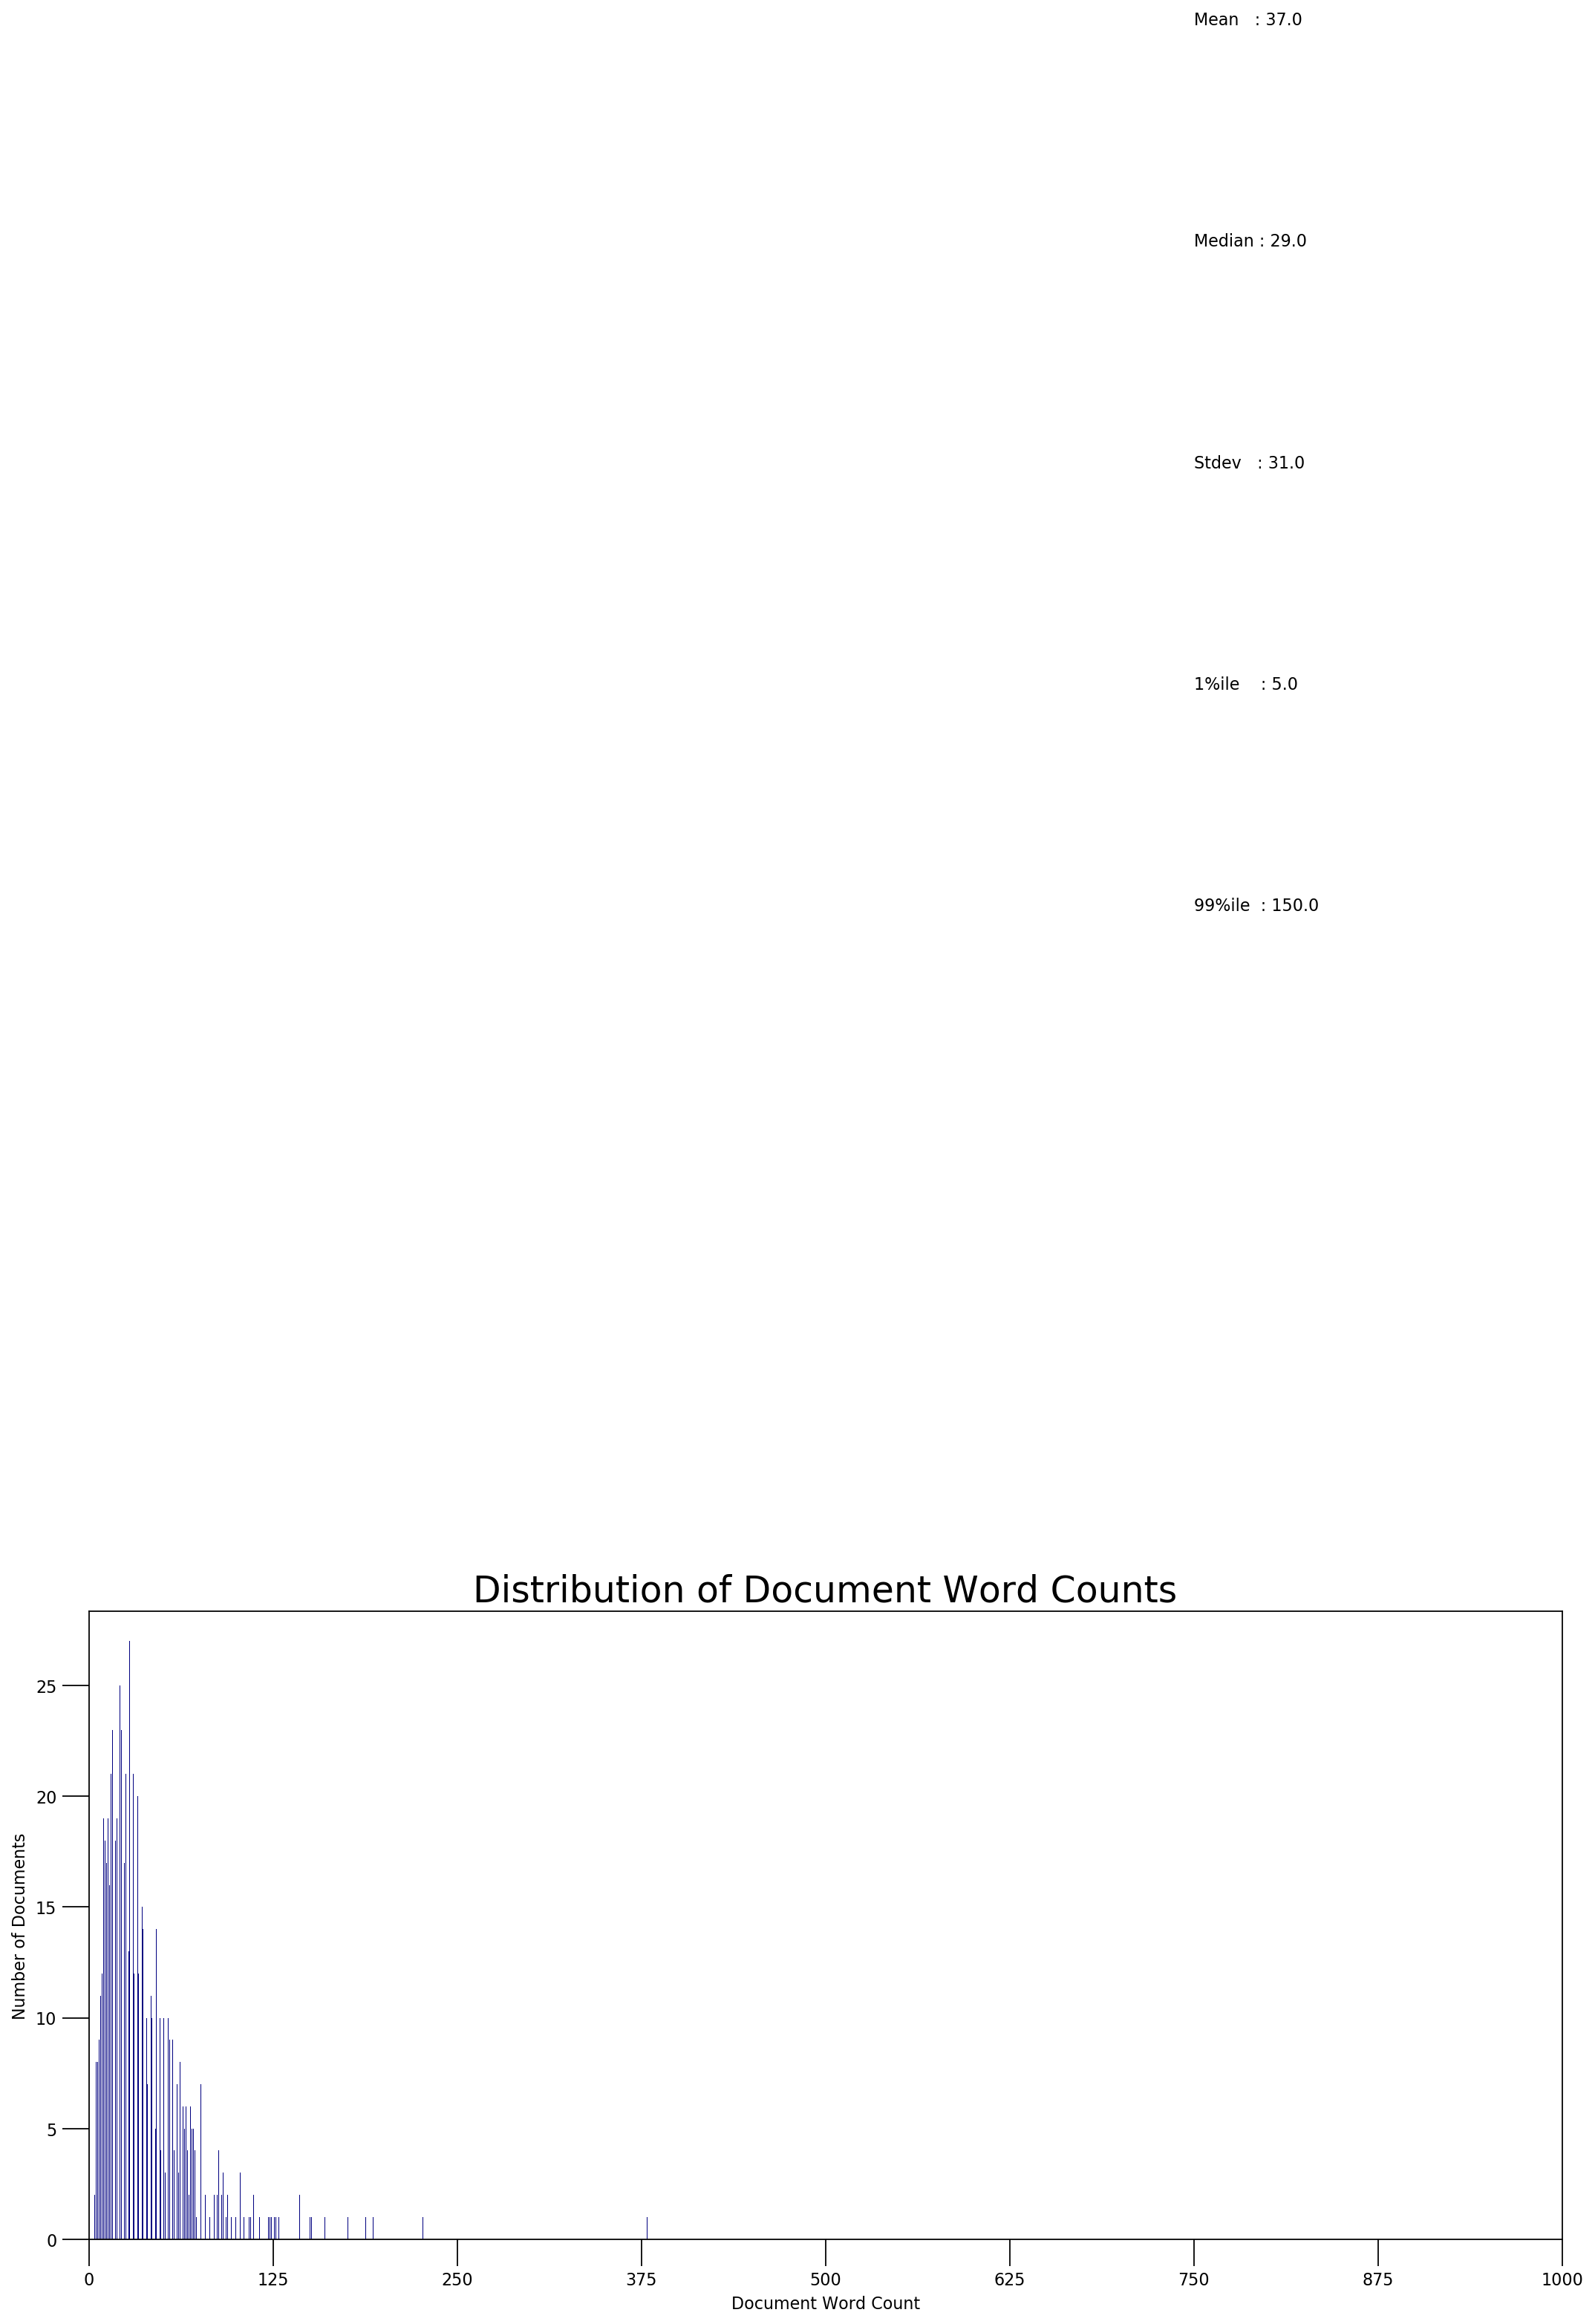

In [370]:

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

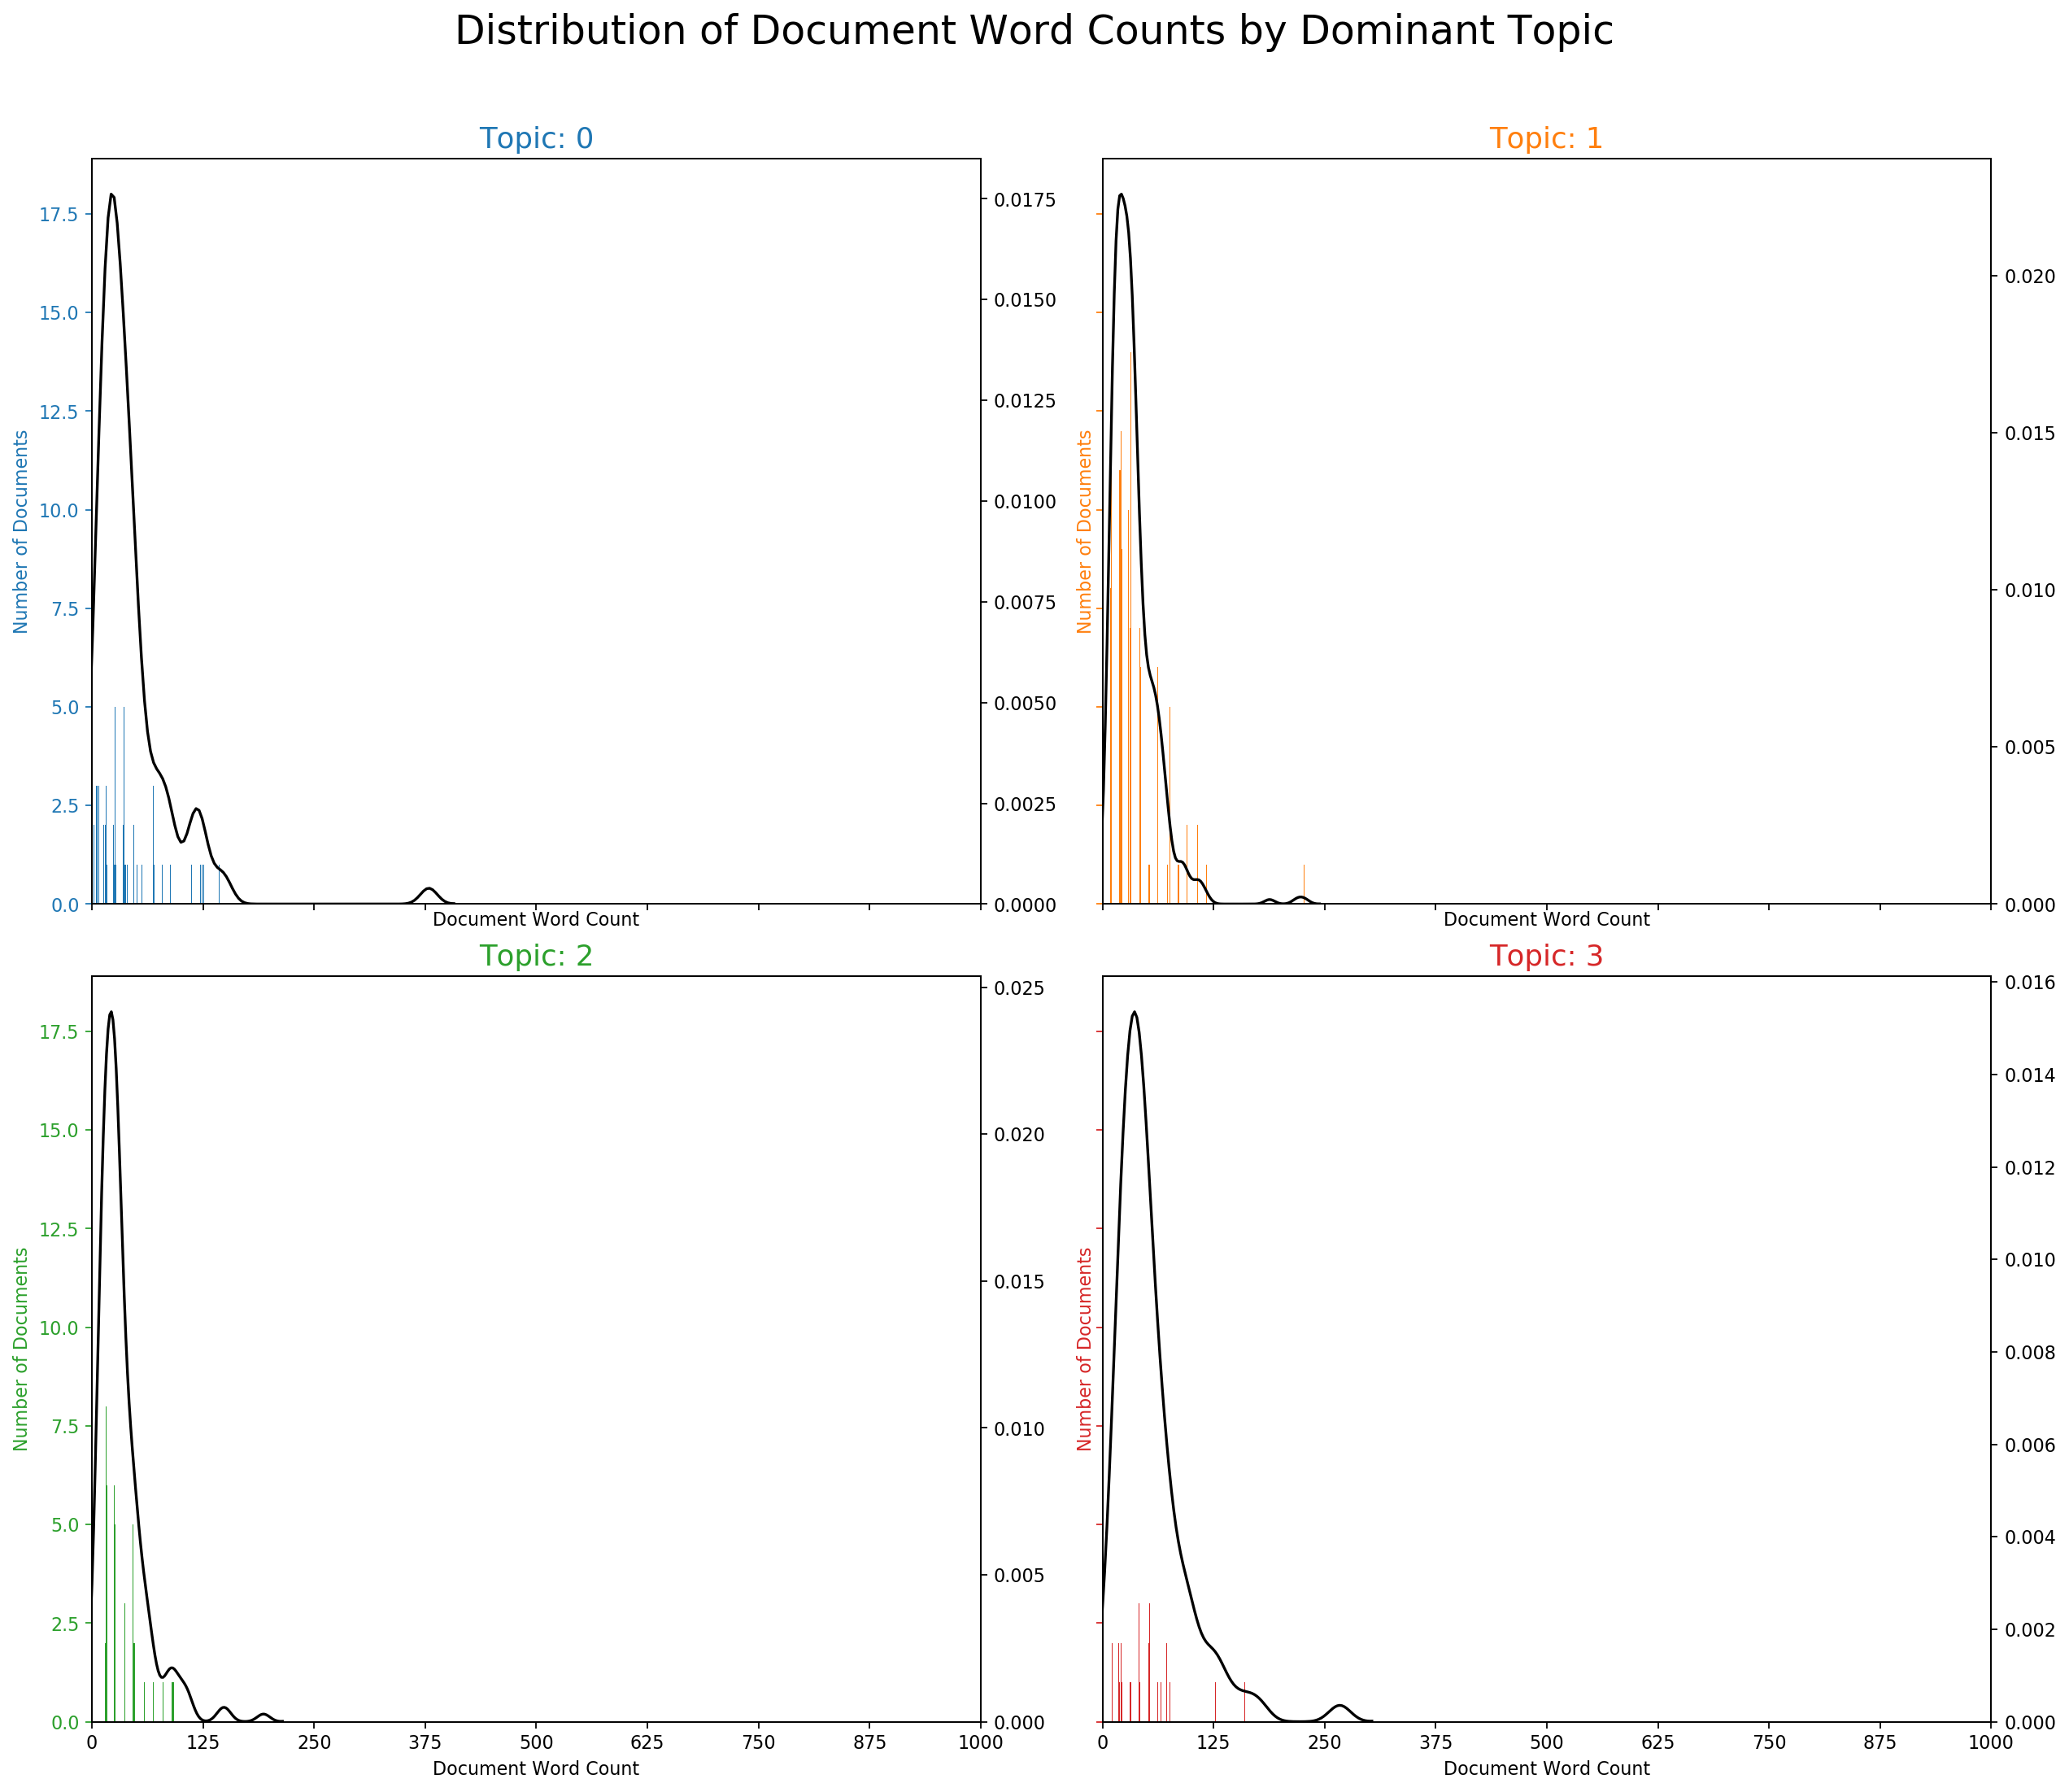

In [371]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## Word Clouds of Top N Keywords in Each Topic

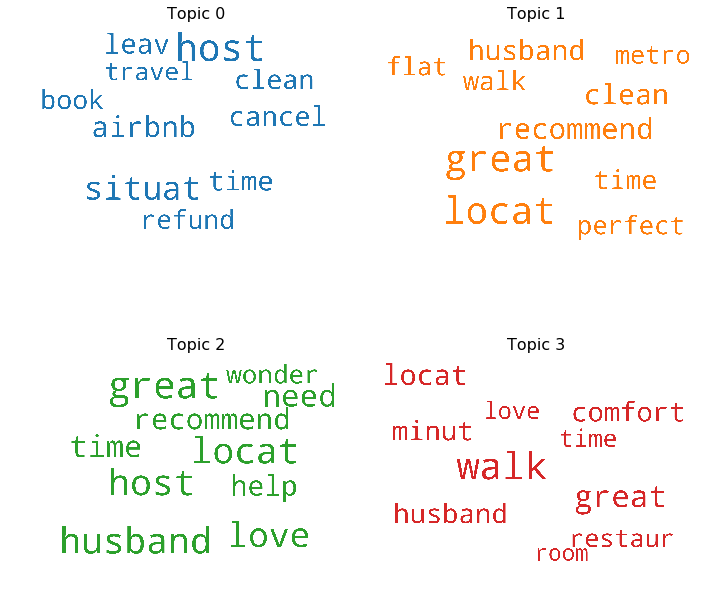

In [392]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords

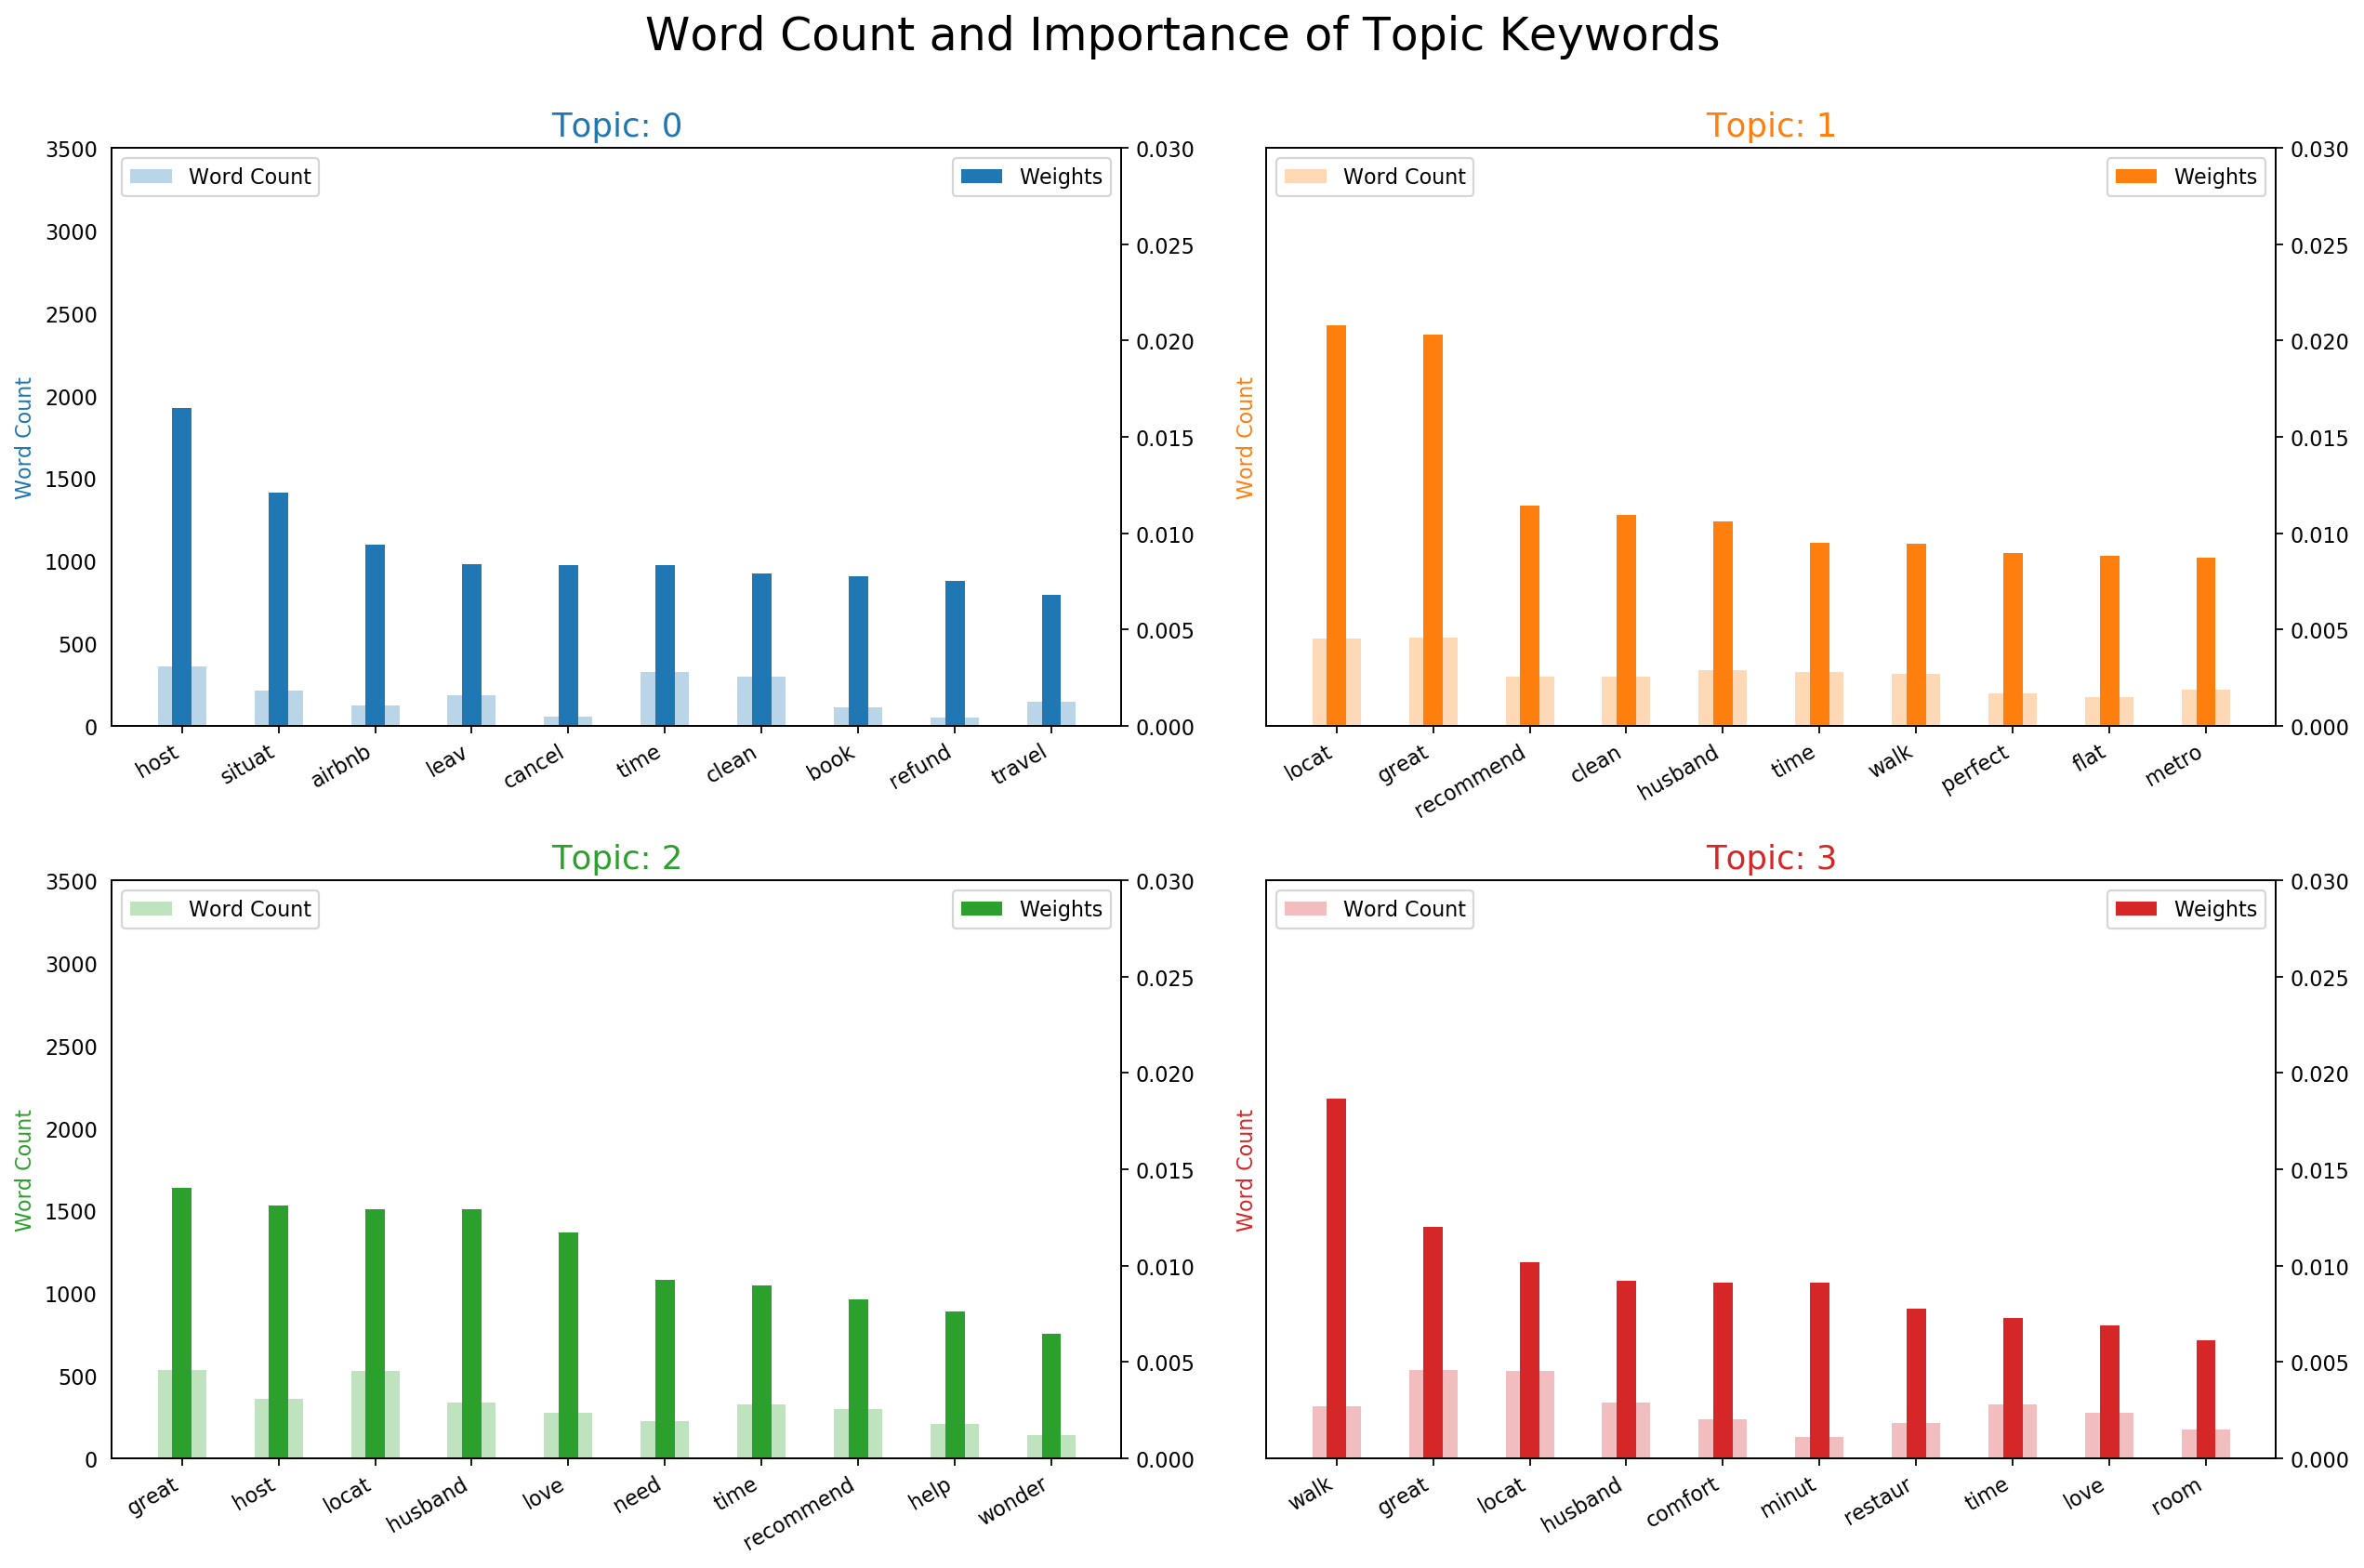

In [373]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in processed_docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## t-SNE Clustering Chart

In [388]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
# topic_weights = []
# for i, row_list in enumerate(lda_model[bow_corpus]):
#     topic_weights.append([w for i, w in row_list[0]])

# n-1 rows each is a vector with i-1 posisitons, where n the number of documents 
# i the topic number and tmp[i] = probability of topic i
topic_weights = []
for row_list in lda_model[bow_corpus]:
    tmp = np.zeros(4)
    for i, w in row_list: 
        tmp[i] = w
        topic_weights.append(tmp)
arr = pd.DataFrame(topic_weights).fillna(0).values

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2286 samples in 0.023s...
[t-SNE] Computed neighbors for 2286 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2286
[t-SNE] Computed conditional probabilities for sample 2000 / 2286
[t-SNE] Computed conditional probabilities for sample 2286 / 2286
[t-SNE] Mean sigma: 0.001846
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.175751
[t-SNE] KL divergence after 1000 iterations: 0.100125


Loading BokehJS ...